In [177]:
import os
import time
import scipy
import timeit
import collections
import numpy as np 
import matplotlib.pyplot as plt  
import matplotlib.ticker as mticker

from scipy.fft import fftfreq, fftn, ifftn, rfftn, rfftfreq
from scipy.special import k0, k1
from scipy.interpolate import RegularGridInterpolator, interpn

from ULDM_Simulator import *

plt.rcParams['text.usetex'] = True
plt.style.use('./myplot.mplstyle')

# Displacement to Acceleration

In this notebook, we investigate the acceleration time series obtained from position time series by applying finite difference method will yield desired spectrum density. In particular, if 

$$
S_x(f) = f^0
$$

We expect 

$$
S_a(f)= f^{-2}
$$

The question we will address in this note book is to which extent the above holds. Below, we computes the acceleration array directly from the position array via

$$
\frac{1}{\Delta t^2} \Big( x_{i+1} - 2 \times x_i + x_{i-1} \Big)
$$

We use the original position array and also the array averaged over a window $\bar x_i = \frac{1}{M} \sum^{M+i-1}_{j=i} x_j$. We see that at the low frequency, the acceleration power spectrum behaves as expected only when averaged over a large enough interval $M$.

In [659]:
def acc_compute(x, dt, accuracy=2, window=False):
    x = np.mean(x.reshape(-1, dt), axis=1)
    n = len(x)
    
    if window:
        wd = np.sin(np.pi * np.arange(0, len(x)) / len(x))**8 
        x = x * wd
        
    if accuracy == 2:
        return dt**(-2) * np.array([x[i+1] - 2 * x[i] + x[i-1] for i in range(1, n-1)])
    elif accuracy == 4: 
        return dt**(-2) * np.array([- 1 / 12 * x[i+2] 
                                    + 4 / 3 * x[i+1]
                                    - 5 / 2 * x[i] 
                                    + 4 / 3 * x[i-1] 
                                    - 1 / 12 * x[i-2] for i in range(2, n-2)])
    else:
        print('Choose accuracy = 2 or 4')

def ps_compute(x, dt):
    return (dt / len(x) * np.abs(rfftn(x))**2)

def ps_compute_avg(Nt=1000,
                   num=10,
                   dt=[1, 2, 5, 10, 20],
                   window=False,
                   ):
    
    x_ps = 0
    a_ps = collections.defaultdict(float)

    for i in range(num):
        x_series = np.random.normal(size=Nt)
        x_ps += ps_compute(x_series, 1) / num
        for j in range(len(dt)):
            a_series = acc_compute(x_series, dt[j], window=window)
            a_ps[dt[j]] += ps_compute(a_series, dt[j]) / num

    return x_ps, a_ps

def ps_plot(Nt=1000,
            num=10,
            dt=[1, 2, 5, 10, 20],
            window=False,
            savefig_loc=None,
            ):
    
    fig, ax = plt.subplots()

    x_ps, a_ps = ps_compute_avg(Nt, num, dt, window)
    x_freq = rfftfreq(Nt, d=1)

    ax.plot(x_freq[1:], x_ps[1:], '.', label=r'$S_x(f)$')
    ax.plot(x_freq[1:], np.ones(len(x_freq[1:])), lw=5, alpha=0.3)
    ax.plot(x_freq[1:], np.ones(len(x_freq[1:])) * (2 * np.pi * x_freq[1:])**4, lw=5, alpha=0.3)

    for d in dt:
        a_freq = rfftfreq(int(Nt/d-2), d=d)
        ax.plot(a_freq[1:], a_ps[d][1:], '+',
                label=rf'$\textrm{{$\Delta t={d}$}}$'
                )

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlim(x_freq[1], x_freq[-1])
    ax.set_xlabel(r'$f\,[\rm Hz]$')
    ax.legend(loc='lower right',
              facecolor='w',
              frameon=True)
    
    fig.tight_layout()
    
    if savefig_loc:
        fig.savefig(savefig_loc)

    return fig, ax

In [589]:
def s_a(f, N, dt):
    n = N//dt
    return 4 / dt**4 / n * (1 + 4 * np.sin(np.pi * f * dt)**2 + 4 * (n - 2) * np.sin(np.pi * f * dt)**4 )

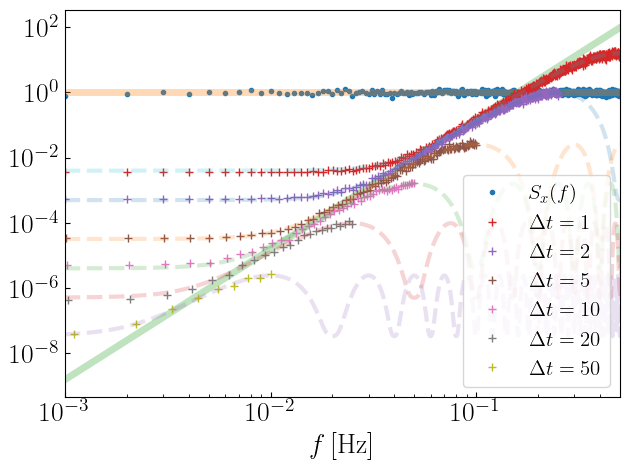

In [645]:
fig, ax = ps_plot(num=100,
                  dt=[1, 2, 5, 10, 20, 50],
                  );

a=0.2
l=3
f = np.logspace(-3,1, 1000)
ax.plot(f, s_a(f, 998, 1), alpha=a, lw=l, linestyle='--')
ax.plot(f, s_a(f, 998, 2), alpha=a, lw=l, linestyle='--')
ax.plot(f, s_a(f, 998, 5), alpha=a, lw=l, linestyle='--')
ax.plot(f, s_a(f, 998, 10), alpha=a, lw=l, linestyle='--')
ax.plot(f, s_a(f, 998, 20), alpha=a, lw=l, linestyle='--')
ax.plot(f, s_a(f, 998, 50), alpha=a, lw=l, linestyle='--')

# fig.savefig('./figs/psd_acc_from_wn.pdf')

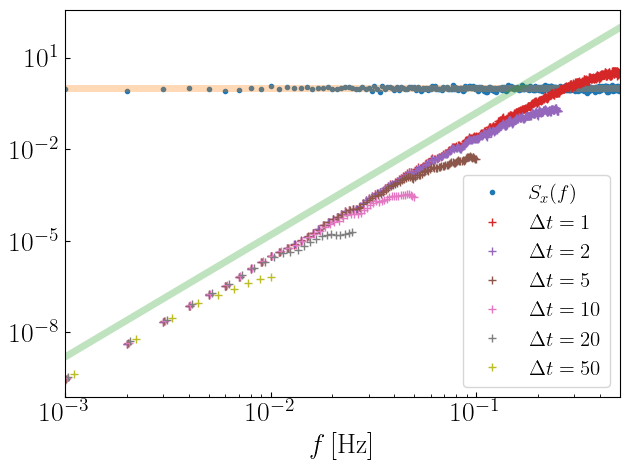

In [660]:
fig, ax = ps_plot(num=100,
                  dt=[1, 2, 5, 10, 20, 50],
                  window=True,
                #   savefig_loc='./figs/psd_acc_from_wn_wd.pdf'
                  );

# fig.savefig('./figs/psd_acc_from_wn.pdf')

Here we take different approach. When computing acceleration array, we use

$$
a_i = \frac{1}{M^2} (\bar x^{(M)}_{i+ 2M} - 2 \bar x^{(M)}_{i+M} + \bar x^{(M)}_{i})
$$

where $\bar x^{(M)}_i$ is defined as

$$
\bar x^{(M)}_i 
= \frac{1}{M} \sum_{j=i}^{M + i -1} \bar x_j
$$

The number of samples for the acceleration array is smaller than the position array by $2M$ factor. Note also that the acceleration values within $i \pm 2M$ are not independent. This must be carefully accounted for when interpreting the resulting power spectrum.

In [431]:
def acc_compute(x, dt):
    n = len(x)
    return dt**(-2) * np.array([np.mean(x[i+2*dt:i+3*dt]) - 2 * np.mean(x[i+dt:i+2*dt]) + np.mean(x[i:i+dt]) for i in range(1, n-2*dt)])

def ps_compute(x, dt):
    return (dt / len(x) * np.abs(rfftn(x))**2)

def ps_compute_avg(Nt=1000,
                   num=10,
                   dt=[1, 2, 5, 10, 20],
                   ):
    
    x_ps = 0
    a_ps = collections.defaultdict(float)

    for i in range(num):
        x_series = np.random.normal(size=Nt)
        x_ps += ps_compute(x_series, 1) / num
        for j in range(len(dt)):
            a_series = acc_compute(x_series, dt[j])
            a_ps[dt[j]] += ps_compute(a_series, 1) / num

    return x_ps, a_ps

def ps_plot(Nt=1000,
            num=10,
            dt=[1, 2, 5, 10, 20],
            ):
    
    fig, ax = plt.subplots()

    x_ps, a_ps = ps_compute_avg(Nt, num, dt)
    x_freq = rfftfreq(Nt, d=1)

    ax.plot(x_freq, x_ps, '.',
            label=r'$S_x(f)$')
    ax.plot(x_freq, np.ones(len(x_freq)), lw=5, alpha=0.3)
    ax.plot(x_freq, np.ones(len(x_freq)) * (2 * np.pi * x_freq)**4, lw=5, alpha=0.3)

    for d in dt:
        a_freq = rfftfreq(Nt - 2*d-1, 1)
        ax.plot(a_freq, a_ps[d], '+', label=rf'$\textrm{{$\Delta t={d}$}}$')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlim(x_freq[1], x_freq[-1])
    ax.set_xlabel(r'$f\,[\rm Hz]$')
    ax.legend()

    fig.tight_layout()

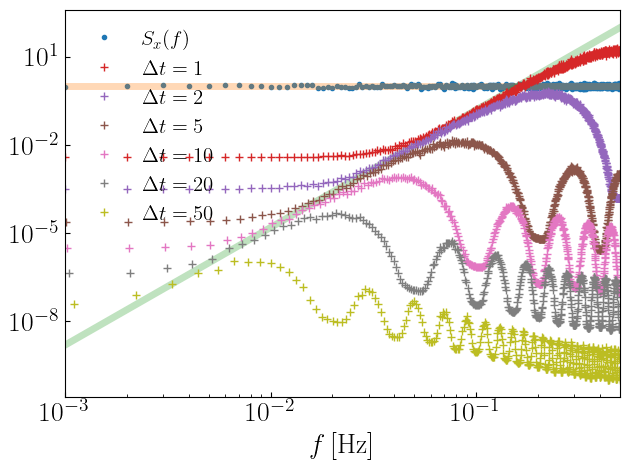

In [439]:
ps_plot(num=100,
        dt=[1, 2, 5, 10, 20, 50])